# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [204]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [434]:
df = pd.read_csv('/content/sample_data/Traffic Data.csv')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [435]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [436]:
df.dropna(inplace=True)

In [437]:
df = df[['date_time','traffic_volume']]

In [438]:
df.head()

,date_time,traffic_volume
0,2017-08-27 01:00:00,1209.0
1,2018-09-06 23:00:00,1248.0
2,2017-08-25 18:00:00,4602.0
3,2017-11-09 22:00:00,2838.0
4,2017-11-09 15:00:00,5794.0


In [439]:
df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True)
df = df.sort_values(by='date_time')

<ipython-input-439-748f21609d1f>:1: UserWarning:

Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



In [440]:
df.drop_duplicates(subset='date_time' , inplace= True)

In [445]:
df.set_index('date_time', inplace=True) # before run this u should run code for Feature Engineering

In [441]:
df = df[::50]# i make data in  326 rows  to understand data

In [442]:
df

,date_time,traffic_volume
7745,2016-11-18 15:00:00,4872.0
11303,2016-11-20 17:00:00,3654.0
7166,2016-11-22 19:00:00,2289.0
14767,2016-11-24 23:00:00,1175.0
4601,2016-11-27 01:00:00,697.0
...,...,...
14792,2018-09-22 09:00:00,3770.0
15446,2018-09-24 11:00:00,4468.0
988,2018-09-26 13:00:00,4624.0
7578,2018-09-28 15:00:00,5838.0


In [238]:
# plt.plot(df)
# plt.show()

In [446]:
import plotly.express as px
fig = px.line(df, y="traffic_volume", title='traffic_volume per DateTime')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [324]:
df

,traffic_volume,prev_traffic_volume,Day_of_Week,Month,Day_of_Year
date_time,,,,,
2016-11-20 17:00:00,3654.0,4872.0,6,11,325
2016-11-22 19:00:00,2289.0,3654.0,1,11,327
2016-11-24 23:00:00,1175.0,2289.0,3,11,329
2016-11-27 01:00:00,697.0,1175.0,6,11,332
2016-11-29 03:00:00,326.0,697.0,1,11,334
...,...,...,...,...,...
2018-09-22 09:00:00,3770.0,5766.0,5,9,265
2018-09-24 11:00:00,4468.0,3770.0,0,9,267
2018-09-26 13:00:00,4624.0,4468.0,2,9,269


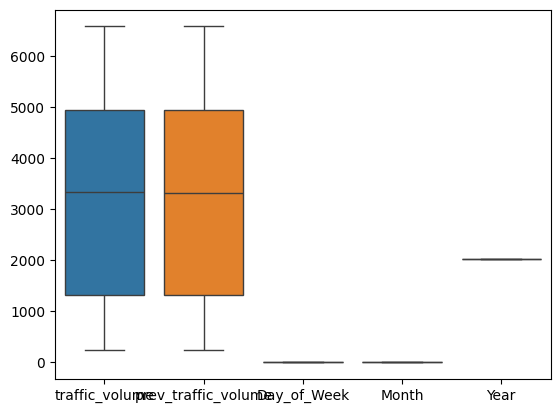

In [447]:
col = ['traffic_volume' , 'prev_traffic_volume' ,	'Day_of_Week' ,	'Month' ,	'Year']
sns.boxplot(df[col])
plt.show()

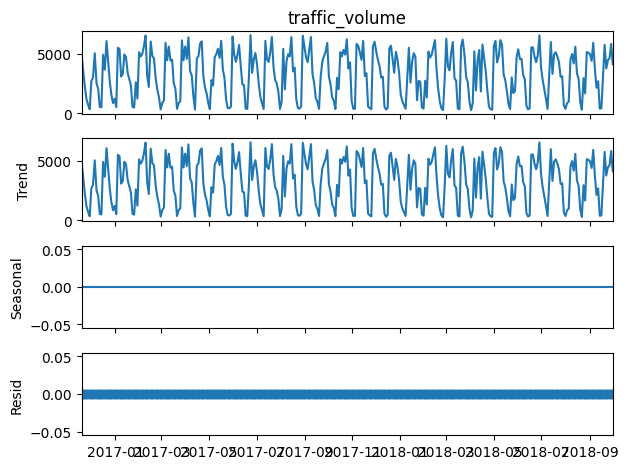

In [448]:
result = seasonal_decompose(df['traffic_volume'], model='additive', period=1)
result.plot()
plt.show()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [399]:
# Make sure that the dates are sorted correctly.
print(df.index)

DatetimeIndex(['2016-11-18 15:00:00', '2016-11-20 17:00:00',
               '2016-11-22 19:00:00', '2016-11-24 23:00:00',
               '2016-11-27 01:00:00', '2016-11-29 03:00:00',
               '2016-12-01 05:00:00', '2016-12-03 08:00:00',
               '2016-12-05 14:00:00', '2016-12-07 21:00:00',
               ...
               '2018-09-11 23:00:00', '2018-09-14 01:00:00',
               '2018-09-16 03:00:00', '2018-09-18 05:00:00',
               '2018-09-20 07:00:00', '2018-09-22 09:00:00',
               '2018-09-24 11:00:00', '2018-09-26 13:00:00',
               '2018-09-28 15:00:00', '2018-09-30 17:00:00'],
              dtype='datetime64[ns]', name='date_time', length=326, freq=None)


In [400]:
df.head()

,traffic_volume,prev_traffic_volume,Day_of_Week,Month,Year
date_time,,,,,
2016-11-18 15:00:00,4872.0,NaN,4,11,2016
2016-11-20 17:00:00,3654.0,4872.0,6,11,2016
2016-11-22 19:00:00,2289.0,3654.0,1,11,2016
2016-11-24 23:00:00,1175.0,2289.0,3,11,2016
2016-11-27 01:00:00,697.0,1175.0,6,11,2016


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [443]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)
df['Day_of_Week'] = df['date_time'].dt.dayofweek
df['Month'] = df['date_time'].dt.month
df['Year'] = df['date_time'].dt.year

In [311]:
df

,traffic_volume,prev_traffic_volume,Day_of_Week,Month,Day_of_Year
date_time,,,,,
2016-11-20 17:00:00,3654.0,4872.0,6,11,325
2016-11-22 19:00:00,2289.0,3654.0,1,11,327
2016-11-24 23:00:00,1175.0,2289.0,3,11,329
2016-11-27 01:00:00,697.0,1175.0,6,11,332
2016-11-29 03:00:00,326.0,697.0,1,11,334
...,...,...,...,...,...
2018-09-22 09:00:00,3770.0,5766.0,5,9,265
2018-09-24 11:00:00,4468.0,3770.0,0,9,267
2018-09-26 13:00:00,4624.0,4468.0,2,9,269


In [450]:

df.dropna(inplace=True)

In [451]:
df.isnull().sum()

,0
traffic_volume,0
prev_traffic_volume,0
Day_of_Week,0
Month,0
Year,0


In [403]:
l = LabelEncoder()
df['Day_of_Week'] = l.fit_transform(df['Day_of_Week'])

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [452]:
# u should run this code before ''create_sequences''
print(X_train.shape, X_test.shape)
print('\n')
print(y_train.shape, y_test.shape)

(220, 50, 1) (55, 50, 1)


(220,) (55,)


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [453]:
df1 = df[['traffic_volume']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [251]:
scaled_data.shape

(324, 1)

In [454]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(df1)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 50  # Using 50 days to predict for 50 days

X, y = create_sequences(scaled_data, seq_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [219]:
# LSTM, or GRU

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [455]:
regressor = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),

    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    LSTM(units=50),
    Dropout(0.2),

    Dense(units=1)
])

regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.2535
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.1317
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.1121
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.1033
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0996
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.1022
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0961
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0975
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0968
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1016
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0990
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0984
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0982
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0956
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1011
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [456]:
prediction_lstm = regressor.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [460]:
df.head()

,traffic_volume,prev_traffic_volume,Day_of_Week,Month,Year
date_time,,,,,
2016-11-20 17:00:00,3654.0,4872.0,6,11,2016
2016-11-22 19:00:00,2289.0,3654.0,1,11,2016
2016-11-24 23:00:00,1175.0,2289.0,3,11,2016
2016-11-27 01:00:00,697.0,1175.0,6,11,2016
2016-11-29 03:00:00,326.0,697.0,1,11,2016


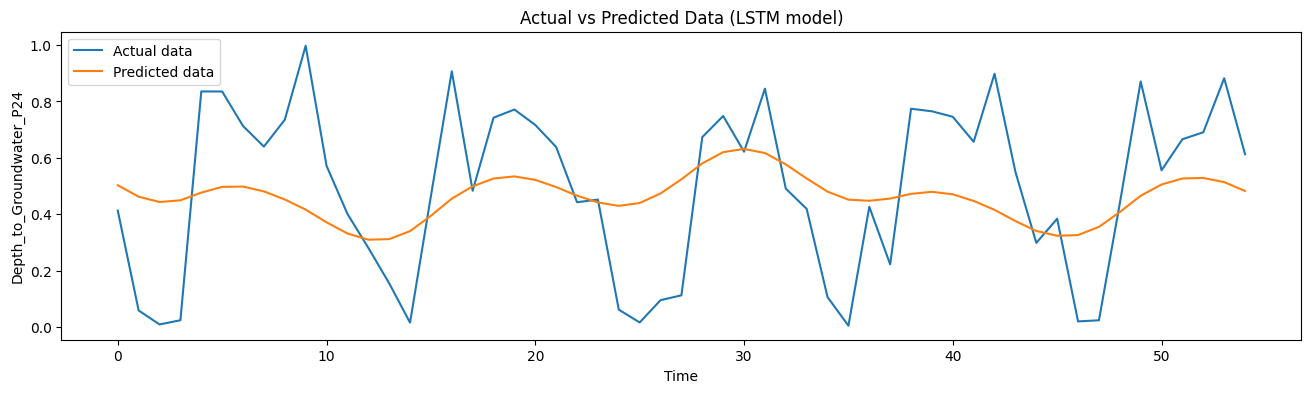

In [476]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, label='Actual data')
plt.plot(prediction_lstm, label='Predicted data')
plt.title('Actual vs Predicted Data (LSTM model)')
plt.xlabel('Time')
plt.ylabel('Depth_to_Groundwater_P24')
plt.legend()
plt.show()

In [305]:
rmse = mean_squared_error(y_test, prediction_lstm)
print(f"Mean Squared Error (MSE): {rmse:.2f}")

rmse = mean_squared_error(y_test, prediction_lstm, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 0.07
Root Mean Squared Error (RMSE): 0.27


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [411]:
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    GRU(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - loss: 0.1743 - val_loss: 0.1208
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.1228 - val_loss: 0.0940
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1083 - val_loss: 0.0994
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1141 - val_loss: 0.0846
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0944 - val_loss: 0.0811
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0964 - val_loss: 0.0762
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0863 - val_loss: 0.0702
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0838 - val_loss: 0.0641
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0700 - val_loss: 0.0577
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0668 - val_loss: 0.0495
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0603 - val_loss: 0.0448
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0517 - val_loss: 0.0429
Epoch 13/20

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [412]:
prediction_gru = model.predict(X_test)

prediction_gru = scaler.inverse_transform(prediction_gru.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

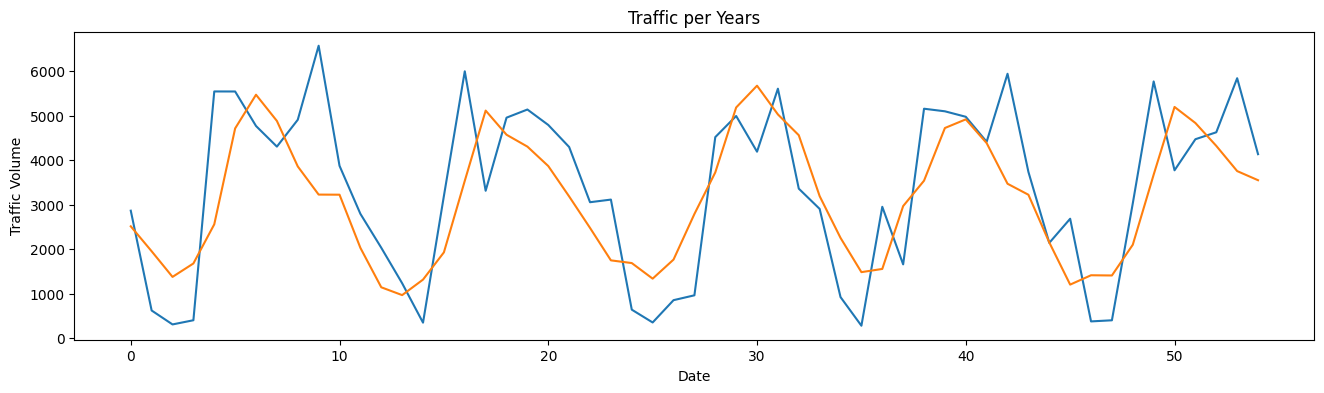

In [415]:
plt.figure(figsize=(16, 4))
plt.plot(y_test_actual, label='Actual data')
plt.plot(prediction_gru, label='Predicted data')
plt.title('Traffic per Years')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

In [414]:
mse = mean_squared_error(y_test_actual, prediction_gru)
print(f"Mean Squared Error (MSE): {mse:.2f}")

rmse = mean_squared_error(y_test_actual, prediction_gru, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 1628982.41
Root Mean Squared Error (RMSE): 1276.32


## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1. i Delete missing values ​​because they are too small compared to the full data size.

2.  in feature engineering I create `prev_traffic_volume` previous day traffic volume  and  `Day_of_Week`, `Month`, and `Year` to account for seasonal patterns forecasting model's accuracy and ability to identify complex traffic behaviors.

3.

-  LSTMs with dropout and  final dense layer the model is designed to provide accurate forecasts for traffic volume based on historical data

-  u can do  in  GRU layers with dense layers provides a powerful framework for accurately predicting traffic volume based on historical data

4. I reduced the data size, which helps in understanding whether the data is a trend or seasonal.

5.
-  I chose (MSE) as the loss function because it emphasizes larger errors, which is crucial in forecasting accurate traffic volumes

-  while (RMSE) as evaluation metric provide comprehensive insights into prediction accuracy and interpretability, aligning with the goal of minimizing forecasting errors effectively.

7. This was there Overfitting I will use  `Dropout(0.2)`.
